In [1]:
import numpy as np
import pandas as pd
import spacy as sp
import tensorflow as tf
import gc, tqdm, copy

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from functools import partial

### A. Examples for estimating uncertainty

In [2]:
fn = "/glade/p/cisl/aiml/fasteddy/idaho_derived_data_20210720.csv"

In [3]:
input_cols = [
    'wind_speed:10_m:m_s-1',
    'potential_temperature_skin_change:10_m:K_m-1',
    'bulk_richardson:10_m:None',
    'mixing_ratio_skin_change:2_m:g_kg-1_m-1'
]
output_cols = ["kinematic_sensible_heat_flux:surface:K_m_s-1"]

In [4]:
data_seed = 0
flat_seed = 1000
n_splits = 10
n_models = 10

data = pd.read_csv(fn)
data["day"] = data["Time"].apply(lambda x: str(x).split(" ")[0])

# Need the same test_data for all trained models (data and model ensembles)
flat_seed = 1000
gsp = GroupShuffleSplit(n_splits=1,  random_state = flat_seed, train_size=0.9)
splits = list(gsp.split(data, groups = data["day"]))
train_index, test_index = splits[0]
train_data, test_data = data.iloc[train_index].copy(), data.iloc[test_index].copy() 

# Make N train-valid splits using day as grouping variable
gsp = GroupShuffleSplit(n_splits=n_splits,  random_state = flat_seed, train_size=0.885)
splits = list(gsp.split(train_data, groups = train_data["day"]))
train_index, valid_index = splits[data_seed]
train_data, valid_data = train_data.iloc[train_index].copy(), train_data.iloc[valid_index] .copy()  

# Set the seed for the model here
#seed_everything(model_seed)

In [5]:
x_scaler, y_scaler = RobustScaler(), MinMaxScaler((0, 1))
x_train = x_scaler.fit_transform(train_data[input_cols])
x_valid = x_scaler.transform(valid_data[input_cols])
x_test = x_scaler.transform(test_data[input_cols])

y_train = y_scaler.fit_transform(train_data[output_cols])
y_valid = y_scaler.transform(valid_data[output_cols])
y_test = y_scaler.transform(test_data[output_cols])

### 1. Standard MLP to predict some quantity

In [6]:
# Write it this way to make it easy for MC dropout

class MLP(tf.keras.Model):

    def __init__(self):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(4500, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(1, activation="linear")
        self.dropout = tf.keras.layers.Dropout(0.25)

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        if training:
            x = self.dropout(x, training=training)
        return self.dense2(x)

mlp = MLP()

In [7]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-5
)

In [8]:
# compile model
mlp.compile(
    optimizer = optimizer, 
    loss = "mae",
    metrics = ['mae'],
    run_eagerly=True
)

In [9]:
# create early stopping callback
callback1 = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_mae', 
    mode = 'min',
    patience = 15,
    restore_best_weights = True
)

# create reduce LR callback
callback2 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_mae', 
    factor = 0.1, 
    patience = 3, 
    verbose = 0,
    mode = 'min',
    min_lr = 1e-7
)

In [10]:
# fit model to training data
history = mlp.fit(
    x = x_train, 
    y = y_train,
    validation_data = (x_valid, y_valid),
    batch_size = 256,
    epochs = 500,
    callbacks = [callback1, callback2],
    verbose = 0
)

In [11]:
y_pred = y_scaler.inverse_transform(mlp.predict(x_test))

In [12]:
mae = np.mean(np.abs(y_pred[:, 0]-test_data[output_cols[0]]))

In [13]:
mae

0.015784952560205755

In [14]:
# del model
# tf.keras.backend.clear_session()
# gc.collect()

### 2. Next, take it one step further with a model for predicting mu and sigma with Gaussian NLL loss

In [15]:
def NLL(y_true, y_pred, reduce = True):
    A = 0.5 * tf.math.log(2 * np.pi * y_pred[:, 1] + 1e-12) 
    B = (y_true[:, 0] - y_pred[:, 0]) ** 2 / (2 * y_pred[:, 1] ** 2 + 1e-12)
    nll = A + B
    return tf.reduce_mean(nll) if reduce else nll

def Gaussian_NLL(y, mu, sigma, reduce=True):
    ax = list(range(1, len(y.shape)))
    logprob = -tf.math.log(sigma) - 0.5*tf.math.log(2*np.pi) - 0.5*((y-mu)/sigma)**2
    loss = tf.reduce_mean(-logprob, axis=ax)
    return tf.reduce_mean(loss) if reduce else loss

def Gaussian_NLL_logvar(y, mu, logvar, reduce=True):
    ax = list(range(1, len(y.shape)))
    log_liklihood = 0.5 * (
        -tf.exp(-logvar)*(mu-y)**2 - tf.math.log(2*tf.constant(np.pi, dtype=logvar.dtype)) - logvar
    )
    loss = tf.reduce_mean(-log_liklihood, axis=ax)
    return tf.reduce_mean(loss) if reduce else loss

In [16]:
data_seed = 0
flat_seed = 1000

data = pd.read_csv(fn)
data["day"] = data["Time"].apply(lambda x: str(x).split(" ")[0])

# Need the same test_data for all trained models (data and model ensembles)
gsp = GroupShuffleSplit(n_splits=1,  random_state = flat_seed, train_size=0.9)
splits = list(gsp.split(data, groups = data["day"]))
train_index, test_index = splits[0]
train_data, test_data = data.iloc[train_index].copy(), data.iloc[test_index].copy() 

# Make N train-valid splits using day as grouping variable
gsp = GroupShuffleSplit(n_splits=n_splits,  random_state = flat_seed, train_size=0.885)
splits = list(gsp.split(train_data, groups = train_data["day"]))
train_index, valid_index = splits[data_seed]
train_data, valid_data = train_data.iloc[train_index].copy(), train_data.iloc[valid_index] .copy()  

x_scaler, y_scaler = RobustScaler(), MinMaxScaler((0, 1))
x_train = x_scaler.fit_transform(train_data[input_cols])
x_valid = x_scaler.transform(valid_data[input_cols])
x_test = x_scaler.transform(test_data[input_cols])

y_train = y_scaler.fit_transform(train_data[output_cols])
y_valid = y_scaler.transform(valid_data[output_cols])
y_test = y_scaler.transform(test_data[output_cols])

In [17]:
class DenseNormal(Layer):
    def __init__(self, units):
        super(DenseNormal, self).__init__()
        self.units = int(units)
        self.dense = Dense(2 * self.units)

    def call(self, x):
        output = self.dense(x)
        mu, logsigma = tf.split(output, 2, axis=-1)
        sigma = tf.nn.softplus(logsigma) + 1e-6
        return tf.concat([mu, sigma], axis=-1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 2 * self.units)

    def get_config(self):
        base_config = super(DenseNormal, self).get_config()
        base_config['units'] = self.units
        return base_config


model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(units = 4500, activation = 'relu'),
        tf.keras.layers.Dropout(0.0),
        tf.keras.layers.Dense(units = 2, activation = 'sigmoid'),
        #DenseNormalGamma(1)
    ]
)

In [18]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-5
)

In [19]:
# compile model
model.compile(
    optimizer = optimizer, 
    loss = NLL,
    metrics = ['mae'],
    run_eagerly=True
)

In [20]:
# create early stopping callback
callback1 = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_mae', 
    mode = 'min',
    patience = 15,
    restore_best_weights = True
)

# create reduce LR callback
callback2 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_mae', 
    factor = 0.1, 
    patience = 3, 
    verbose = 0,
    mode = 'min',
    min_lr = 1e-7
)

In [21]:
# fit model to training data
history = model.fit(
    x = x_train, 
    y = y_train,
    validation_data = (x_valid, y_valid),
    batch_size = 256,
    epochs = 500,
    callbacks = [callback1, callback2],
    verbose = 2
)

Epoch 1/500
116/116 - 2s - loss: 9719301.0000 - mae: 0.2427 - val_loss: 0.6706 - val_mae: 0.2422 - lr: 1.0000e-05 - 2s/epoch - 15ms/step
Epoch 2/500
116/116 - 2s - loss: 6528479.5000 - mae: 0.2396 - val_loss: 0.6578 - val_mae: 0.2395 - lr: 1.0000e-05 - 2s/epoch - 14ms/step
Epoch 3/500
116/116 - 2s - loss: 10009535.0000 - mae: 0.2371 - val_loss: 0.6499 - val_mae: 0.2370 - lr: 1.0000e-05 - 2s/epoch - 13ms/step
Epoch 4/500
116/116 - 2s - loss: 5033276.5000 - mae: 0.2348 - val_loss: 0.6465 - val_mae: 0.2348 - lr: 1.0000e-05 - 2s/epoch - 14ms/step
Epoch 5/500
116/116 - 2s - loss: 6978234.0000 - mae: 0.2327 - val_loss: 0.6418 - val_mae: 0.2326 - lr: 1.0000e-05 - 2s/epoch - 14ms/step
Epoch 6/500
116/116 - 2s - loss: 6978234.0000 - mae: 0.2308 - val_loss: 0.6373 - val_mae: 0.2307 - lr: 1.0000e-05 - 2s/epoch - 14ms/step
Epoch 7/500
116/116 - 2s - loss: 6978234.0000 - mae: 0.2290 - val_loss: 0.6334 - val_mae: 0.2290 - lr: 1.0000e-05 - 2s/epoch - 14ms/step
Epoch 8/500
116/116 - 2s - loss: 6978234

In [22]:
y_pred = model.predict(x_test)

In [23]:
# compute variance and std from learned parameters
mu, var = (y_pred[:, i] for i in range(y_pred.shape[1]))

In [24]:
train_data[output_cols].var().to_numpy()[0]

0.010781968922241677

In [25]:
mu = y_scaler.inverse_transform(np.expand_dims(mu, axis = 1)).squeeze(-1)
var = np.expand_dims(var, axis = 1).squeeze(-1)
var *= train_data[output_cols].var().to_numpy()[0]

In [26]:
mae = np.mean(np.abs(mu-test_data[output_cols[0]]))
print(mae, np.mean(var) ** (1/2))

0.026031230724743136 0.0452591965858977


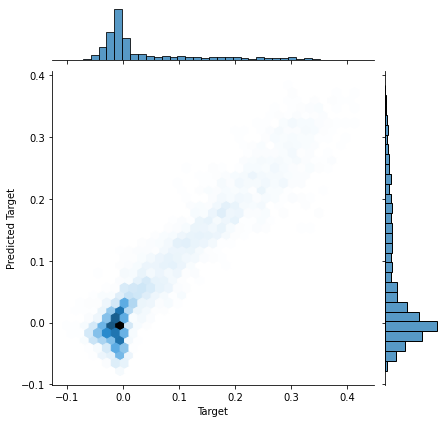

In [27]:
sns.jointplot(x = test_data[output_cols[0]], y = mu, kind = 'hex')
plt.xlabel('Target')
plt.ylabel('Predicted Target')
plt.show()

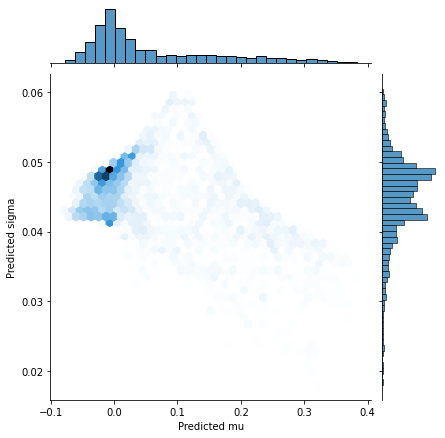

In [28]:
sns.jointplot(x = mu, y = np.sqrt(var), kind = 'hex')
plt.xlabel('Predicted mu')
plt.ylabel('Predicted sigma')
plt.show()

In [29]:
# del model
# tf.keras.backend.clear_session()
# gc.collect()

### B. Compute uncertanties 

### 1a. First with the standard model via MC dropout sampling

In [30]:
def get_monte_carlo_predictions(x_test, 
                                forward_passes,
                                model,
                                n_samples):
    """ Function to get the monte-carlo samples and uncertainty estimates
    through multiple forward passes

    Parameters
    ----------
    data_loader : object
        data loader object from the data loader module
    forward_passes : int
        number of monte-carlo samples/forward passes
    model : object
        keras model
    n_classes : int
        number of classes in the dataset
    n_samples : int
        number of samples in the test set
    """

    dropout_predictions = np.empty((0, n_samples, 1))
    for i in range(forward_passes):
        predictions = np.empty((0, 1))
        output = y_scaler.inverse_transform(model.call(x_test, training=True))
        predictions = np.vstack((predictions, output))
        dropout_predictions = np.vstack((dropout_predictions,
                                         predictions[np.newaxis, :, :]))
        # dropout predictions - shape (forward_passes, n_samples, n_classes)
    
    # Calculating mean across multiple MCD forward passes 
    mean = np.mean(dropout_predictions, axis=0) # shape (n_samples, n_classes)

    # Calculating variance across multiple MCD forward passes 
    variance = np.var(dropout_predictions, axis=0) # shape (n_samples, n_classes)
    
    return mean, variance

In [31]:
forward_passes = 1000
n_samples = x_test.shape[0]

mu, sigma = get_monte_carlo_predictions(x_test,
                                        forward_passes,
                                        mlp,
                                        n_samples)

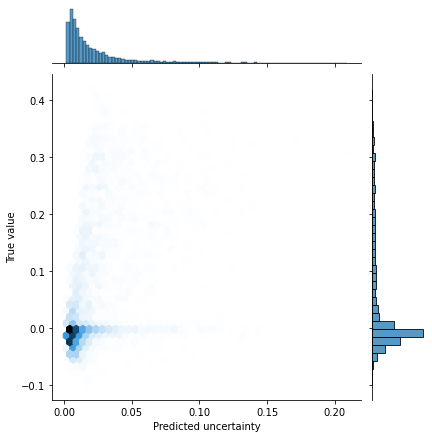

In [32]:
sns.jointplot(x = np.sqrt(sigma[:, 0]), y = test_data[output_cols[0]], kind = 'hex')
plt.xlabel('Predicted uncertainty')
plt.ylabel('True value')
plt.show()

### 1b. Create ensemble of ensembles with standard MLP to compute evidential components

In [33]:
ensemble_mu = np.zeros((n_models, test_data.shape[0], 1))
ensemble_sigma = np.zeros((n_models, test_data.shape[0], 1))

for model_seed in range(n_models):

    _model = MLP()
    _ensemble_pred = np.zeros((n_splits, test_data.shape[0], 1))
    
    for data_seed in tqdm.tqdm(range(n_splits)):
        data = pd.read_csv(fn)
        data["day"] = data["Time"].apply(lambda x: str(x).split(" ")[0])

        # Need the same test_data for all trained models (data and model ensembles)
        flat_seed = 1000
        gsp = GroupShuffleSplit(n_splits=1,  random_state = flat_seed, train_size=0.9)
        splits = list(gsp.split(data, groups = data["day"]))
        train_index, test_index = splits[0]
        train_data, test_data = data.iloc[train_index].copy(), data.iloc[test_index].copy() 

        # Make N train-valid splits using day as grouping variable
        gsp = GroupShuffleSplit(n_splits=n_splits,  random_state = flat_seed, train_size=0.885)
        splits = list(gsp.split(train_data, groups = train_data["day"]))
        train_index, valid_index = splits[data_seed]
        train_data, valid_data = train_data.iloc[train_index].copy(), train_data.iloc[valid_index] .copy()  

        x_scaler, y_scaler = RobustScaler(), MinMaxScaler((0, 1))
        x_train = x_scaler.fit_transform(train_data[input_cols])
        x_valid = x_scaler.transform(valid_data[input_cols])
        x_test = x_scaler.transform(test_data[input_cols])

        y_train = y_scaler.fit_transform(train_data[output_cols])
        y_valid = y_scaler.transform(valid_data[output_cols])
        y_test = y_scaler.transform(test_data[output_cols])

        optimizer = tf.keras.optimizers.Adam(
            learning_rate=1e-5
        )
        
        model = copy.deepcopy(_model)

        # compile model
        model.compile(
            optimizer = optimizer, 
            loss = "mae",
            metrics = ['mae'],
            run_eagerly=True
        )

        callback1 = tf.keras.callbacks.EarlyStopping(
            monitor = 'val_mae', 
            mode = 'min',
            patience = 15,
            restore_best_weights = True
        )
        callback2 = tf.keras.callbacks.ReduceLROnPlateau(
            monitor = 'val_mae', 
            factor = 0.1, 
            patience = 3, 
            verbose = 0,
            mode = 'min',
            min_lr = 1e-7
        )
        # fit model to training data
        history = model.fit(
            x = x_train, 
            y = y_train,
            validation_data = (x_valid, y_valid),
            batch_size = 256,
            epochs = 500,
            callbacks = [callback1, callback2],
            verbose = 0
        )

        _ensemble_pred[data_seed] = y_scaler.inverse_transform(model.predict(x_test))
        
        del model
        tf.keras.backend.clear_session()
        gc.collect()

    ensemble_mu[model_seed] = np.mean(_ensemble_pred, 0)
    ensemble_sigma[model_seed] = np.var(_ensemble_pred, 0)

100%|██████████| 10/10 [09:58<00:00, 59.83s/it]


In [34]:
mlp_aleatoric = np.mean(ensemble_sigma, 0)
mlp_epistemic = np.var(ensemble_mu, 0)

In [35]:
print(mlp_epistemic.mean() ** (1/2), mlp_aleatoric.mean() ** (1/2))

0.000542891349707717 0.0024902650909771557


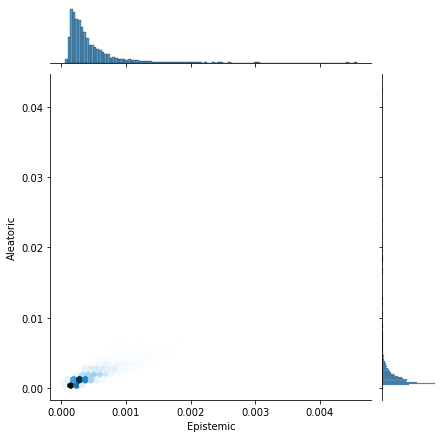

In [36]:
sns.jointplot(x = np.sqrt(mlp_epistemic[:, 0]), y = np.sqrt(mlp_aleatoric[:, 0]), kind = 'hex')
plt.xlabel('Epistemic')
plt.ylabel('Aleatoric')
plt.show()

### 2. Next with the Gaussian model, create a deep ensemble

In [37]:
data_seed = 0
gsp = GroupShuffleSplit(n_splits=1,  random_state = flat_seed, train_size=0.9)
splits = list(gsp.split(data, groups = data["day"]))
train_index, test_index = splits[0]

In [38]:
ensemble_mu = np.zeros((n_splits, test_data.shape[0], 1))
ensemble_var = np.zeros((n_splits, test_data.shape[0], 1))

for data_seed in tqdm.tqdm(range(n_splits)):
    data = pd.read_csv(fn)
    data["day"] = data["Time"].apply(lambda x: str(x).split(" ")[0])

    # Need the same test_data for all trained models (data and model ensembles)
    flat_seed = 1000
    gsp = GroupShuffleSplit(n_splits=1,  random_state = flat_seed, train_size=0.9)
    splits = list(gsp.split(data, groups = data["day"]))
    train_index, test_index = splits[0]
    train_data, test_data = data.iloc[train_index].copy(), data.iloc[test_index].copy() 

    # Make N train-valid splits using day as grouping variable
    gsp = GroupShuffleSplit(n_splits=n_splits,  random_state = flat_seed, train_size=0.885)
    splits = list(gsp.split(train_data, groups = train_data["day"]))
    train_index, valid_index = splits[data_seed]
    train_data, valid_data = train_data.iloc[train_index].copy(), train_data.iloc[valid_index] .copy()  

    x_scaler, y_scaler = RobustScaler(), MinMaxScaler((0, 1))
    x_train = x_scaler.fit_transform(train_data[input_cols])
    x_valid = x_scaler.transform(valid_data[input_cols])
    x_test = x_scaler.transform(test_data[input_cols])

    y_train = y_scaler.fit_transform(train_data[output_cols])
    y_valid = y_scaler.transform(valid_data[output_cols])
    y_test = y_scaler.transform(test_data[output_cols])
    
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(units = 4500, activation = 'relu'),
            #tf.keras.layers.Dropout(),
            tf.keras.layers.Dense(units = 2, activation = 'sigmoid'),
        ]
    )
    
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=1e-5
    )
    
    # compile model
    model.compile(
        optimizer = optimizer, 
        loss = NLL,
        metrics = ['mae'],
        run_eagerly=True
    )
    
    callback1 = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_mae', 
        mode = 'min',
        patience = 15,
        restore_best_weights = True
    )
    callback2 = tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_mae', 
        factor = 0.1, 
        patience = 3, 
        verbose = 0,
        mode = 'min',
        min_lr = 1e-7
    )
    # fit model to training data
    history = model.fit(
        x = x_train, 
        y = y_train,
        validation_data = (x_valid, y_valid),
        batch_size = 256,
        epochs = 500,
        callbacks = [callback1, callback2],
        verbose = 0
    )
    
    y_pred = model.predict(x_test)
    mu, var = (y_pred[:, i] for i in range(y_pred.shape[1]))
    mu = y_scaler.inverse_transform(np.expand_dims(mu, axis = 1)).squeeze(-1)
    var = np.expand_dims(var, axis = 1).squeeze(-1)
    var *= train_data[output_cols].var().to_numpy()[0]
    mae = np.mean(np.abs(mu-test_data[output_cols[0]]))
    
    ensemble_mu[data_seed] = np.expand_dims(mu, 1)
    ensemble_var[data_seed] = np.expand_dims(var, 1)
    
    del model
    tf.keras.backend.clear_session()
    gc.collect()

100%|██████████| 10/10 [14:55<00:00, 89.55s/it]


In [39]:
epistemic = np.var(ensemble_mu, axis=0)
aleatoric = np.mean(ensemble_var, axis=0)

In [40]:
print(epistemic.mean() ** (1/2), aleatoric.mean() ** (1/2))

0.04904076462552248 0.045809163832760035


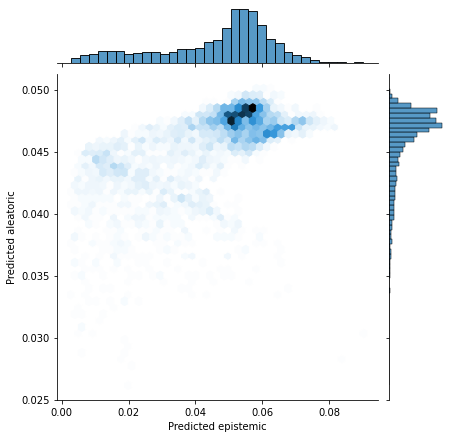

In [41]:
sns.jointplot(x = np.sqrt(epistemic[:, 0]), y = np.sqrt(aleatoric[:, 0]), kind = 'hex')
plt.xlabel('Predicted epistemic')
plt.ylabel('Predicted aleatoric')
plt.show()

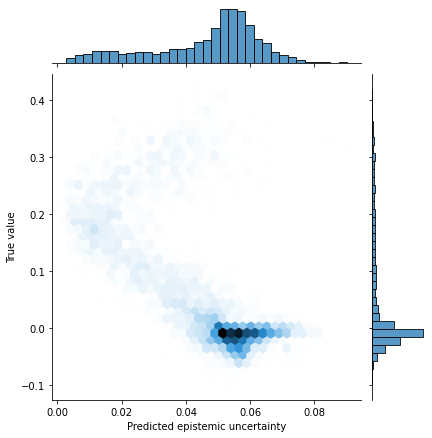

In [42]:
sns.jointplot(x = np.sqrt(epistemic[:, 0]), y = test_data[output_cols[0]], kind = 'hex')
plt.xlabel('Predicted epistemic uncertainty')
plt.ylabel('True value')
plt.show()

### 3. Finally, with the normal inverse gamma approach for estimating evidential uncertainty

In [43]:
class DenseNormalGamma(tf.keras.layers.Layer):
    """Implements dense layer for Deep Evidential Regression
    
    Reference: https://www.mit.edu/~amini/pubs/pdf/deep-evidential-regression.pdf
    Source: https://github.com/aamini/evidential-deep-learning
    """
    
    def __init__(self, units):
        super(DenseNormalGamma, self).__init__()
        self.units = int(units)
        self.dense = tf.keras.layers.Dense(4 * self.units, activation=None)

    def evidence(self, x):
        return tf.nn.softplus(x)

    def call(self, x):
        output = self.dense(x)
        mu, logv, logalpha, logbeta = tf.split(output, 4, axis=-1)
        v = self.evidence(logv)
        alpha = self.evidence(logalpha) + 1
        beta = self.evidence(logbeta)
        return tf.concat([mu, v, alpha, beta], axis=-1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 4 * self.units)

    def get_config(self):
        base_config = super(DenseNormalGamma, self).get_config()
        base_config['units'] = self.units
        return base_config

In [44]:
def NIG_NLL(y, gamma, v, alpha, beta, reduce=True):
    v += 1e-12
    twoBlambda = 2*beta*(1+v) + 1e-12
    nll = 0.5*tf.math.log(np.pi/v)  \
        - alpha*tf.math.log(twoBlambda)  \
        + (alpha+0.5) * tf.math.log(v*(y-gamma)**2 + twoBlambda)  \
        + tf.math.lgamma(alpha)  \
        - tf.math.lgamma(alpha+0.5)

    return tf.reduce_mean(nll) if reduce else nll

def NIG_Reg(y, gamma, v, alpha, beta, reduce=True):
    error = tf.abs(y-gamma)
    evi = 2*v+(alpha)
    reg = error*evi

    return tf.reduce_mean(reg) if reduce else reg

def EvidentialRegression(y_true, evidential_output, coeff=1.0):
    """Implements loss for Deep Evidential Regression
    
    Reference: https://www.mit.edu/~amini/pubs/pdf/deep-evidential-regression.pdf
    Source: https://github.com/aamini/evidential-deep-learning
    """
    
    gamma, v, alpha, beta = tf.split(evidential_output, 4, axis=-1)
    loss_nll = NIG_NLL(y_true, gamma, v, alpha, beta)
    loss_reg = NIG_Reg(y_true, gamma, v, alpha, beta)
    return loss_nll + coeff * loss_reg

In [45]:
data_seed = 0
flat_seed = 1000

data = pd.read_csv(fn)
data["day"] = data["Time"].apply(lambda x: str(x).split(" ")[0])

# Need the same test_data for all trained models (data and model ensembles)
gsp = GroupShuffleSplit(n_splits=1,  random_state = flat_seed, train_size=0.9)
splits = list(gsp.split(data, groups = data["day"]))
train_index, test_index = splits[0]
train_data, test_data = data.iloc[train_index].copy(), data.iloc[test_index].copy() 

# Make N train-valid splits using day as grouping variable
gsp = GroupShuffleSplit(n_splits=n_splits,  random_state = flat_seed, train_size=0.885)
splits = list(gsp.split(train_data, groups = train_data["day"]))
train_index, valid_index = splits[data_seed]
train_data, valid_data = train_data.iloc[train_index].copy(), train_data.iloc[valid_index] .copy()  

x_scaler, y_scaler = RobustScaler(), MinMaxScaler((0, 1))
x_train = x_scaler.fit_transform(train_data[input_cols])
x_valid = x_scaler.transform(valid_data[input_cols])
x_test = x_scaler.transform(test_data[input_cols])

y_train = y_scaler.fit_transform(train_data[output_cols])
y_valid = y_scaler.transform(valid_data[output_cols])
y_test = y_scaler.transform(test_data[output_cols])

In [46]:
evm = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(units = 4500, activation = 'relu'),
        #tf.keras.layers.Dropout(),
        DenseNormalGamma(1)
    ]
)

In [47]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-5
)

In [48]:
loss = partial(EvidentialRegression, coeff=0.05)

# compile model
evm.compile(
    optimizer = optimizer, 
    loss = loss,
    metrics = ['mae']
)

In [49]:
callback1 = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min',
    patience = 15,
    restore_best_weights = True
)

# create reduce LR callback
callback2 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.1, 
    patience = 3, 
    verbose = 0,
    mode = 'min'
)

In [50]:
# fit model to training data
history = evm.fit(
    x = x_train, 
    y = y_train,
    validation_data = (x_valid, y_valid),
    batch_size = 256,
    epochs = 500,
    callbacks = [callback1, callback2],
    verbose = 0
)

In [51]:
y_pred = evm.predict(x_test)

In [52]:
# compute variance and std from learned parameters
mu, v, alpha, beta = (y_pred[:, i] for i in range(y_pred.shape[1]))
var_a = beta / (alpha - 1)
var_e = beta / (v * (alpha - 1))

In [53]:
mu = y_scaler.inverse_transform(mu.reshape((mu.shape[0], -1)))
var_a *= train_data[output_cols[0]].var()
var_e *= train_data[output_cols[0]].var()

In [54]:
mae = np.mean(np.abs(mu[:, 0]-test_data[output_cols[0]]))
var = np.var(np.abs(mu[:, 0]-test_data[output_cols[0]]))
print(mae, var, np.sqrt(var_e).mean(), np.sqrt(var_a).mean())

0.014671666517423652 0.0002717661906240611 0.0018595479 0.003198621


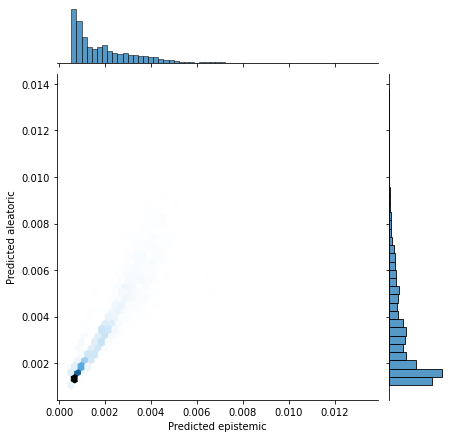

In [55]:
sns.jointplot(x = np.sqrt(var_e), y = np.sqrt(var_a), kind = 'hex')
plt.xlabel('Predicted epistemic')
plt.ylabel('Predicted aleatoric')
plt.show()

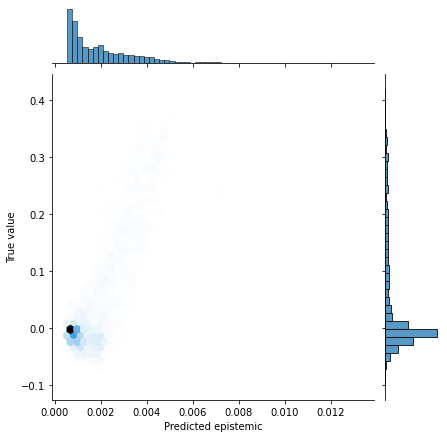

In [56]:
sns.jointplot(x = np.sqrt(var_e), y = test_data[output_cols[0]].to_numpy(), kind = 'hex')
plt.xlabel('Predicted epistemic')
plt.ylabel('True value')
plt.show()